# Summary

Goal:
- Find the best linear model that predicts the outcome of a product.

Steps:
- Trained linear models using different combinations of features and parameters.

Result:
- The best performing one is a Ridge Logistic Regression with parameters and\
  training dataset:
  - inverse regularization value c=1e-06
  - features used: "ordered_before", "abandoned_before", "global_popularity",\
    "set_as_regular", "active_snoozed"
  - threshold: 0.01821537339520326 (can be changed depending on business\
    requirements)

# Beginning of model analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

plt.style.use("ggplot")

In [2]:
data_path = "../../data/feature_frame.csv"
df = pd.read_csv(data_path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

### Classification of each feature


In [4]:
target_col = "outcome"
info_cols = ["variant_id", "order_id", "user_id", "created_at", "order_date"]

features_cols = [col for col in df.columns if col not in info_cols + [target_col]]
categorical_cols = ["product_type", "vendor"]
binary_cols = ["ordered_before", "abandoned_before", "active_snoozed", "set_as_regular"]
numerical_cols = [
    "normalised_price",
    "discount_pct",
    "global_popularity",
    "count_adults",
    "count_children",
    "count_babies",
    "count_pets",
    "people_ex_baby",
    "days_since_purchase_variant_id",
    "avg_days_to_buy_variant_id",
    "std_days_to_buy_variant_id",
    "days_since_purchase_product_type",
    "avg_days_to_buy_product_type",
    "std_days_to_buy_product_type",
]

### Cleaning and Filtering the dataset


In [5]:
def filter_orders_with_minimum_size(
    df: pd.DataFrame, min_size: int = 5
) -> pd.DataFrame:
    """
    Filter orders that have at least 5 products
    """
    filt = df.query("outcome == 1.0").groupby("order_id").size() >= min_size
    order_ids = set(filt[filt].index)
    filtered_df = df[df["order_id"].isin(order_ids)]
    return filtered_df


selected_df = (
    df.pipe(filter_orders_with_minimum_size, min_size=5)
    .assign(created_at=lambda x: pd.to_datetime(x.created_at))
    .assign(order_date=lambda x: pd.to_datetime(x.order_date))
    .sort_values("order_date")
)

### Split dataset into train, validation and test


We will do a temporal split of the orders to avoid information leakage between\
splits, as future orders may contain information or dynamics of previous orders.\
Perform following split:

- train order dates <= validation order dates <= test order dates


In [6]:
def get_train_val_test_with_temporal_split_orders(
    df: pd.DataFrame,
    train_proportion: float,
    val_proportion: float,
    test_proportion: float,
):
    unique_orders = df.drop_duplicates(subset=["order_id"])[["order_id", "order_date"]]
    total_orders = len(unique_orders)

    train_count = int(total_orders * train_proportion)
    val_count = int(total_orders * val_proportion)
    test_count = total_orders - train_count - val_count

    train_orders = unique_orders.iloc[:train_count]["order_id"]
    val_orders = unique_orders.iloc[train_count : train_count + val_count]["order_id"]
    test_orders = unique_orders.iloc[train_count + val_count :]["order_id"]

    train_data = df[df["order_id"].isin(train_orders)]
    val_data = df[df["order_id"].isin(val_orders)]
    test_data = df[df["order_id"].isin(test_orders)]
    return train_data, val_data, test_data

In [7]:
train_proportion = 0.7
val_proportion = 0.2
test_proportion = 0.1

train_data, val_data, test_data = get_train_val_test_with_temporal_split_orders(
    selected_df, train_proportion, val_proportion, test_proportion
)

In [8]:
print("Train start date:", train_data["order_date"].iloc[0])
print("Train end date:", train_data["order_date"].iloc[-1])
print("Validation start date:", val_data["order_date"].iloc[0])
print("Validation end date:", val_data["order_date"].iloc[-1])
print("Test start date:", test_data["order_date"].iloc[0])
print("Test end date:", test_data["order_date"].iloc[-1])
assert train_data["order_date"].iloc[0] <= train_data["order_date"].iloc[-1]
assert train_data["order_date"].iloc[-1] <= val_data["order_date"].iloc[0]
assert val_data["order_date"].iloc[0] <= val_data["order_date"].iloc[-1]
assert val_data["order_date"].iloc[-1] <= test_data["order_date"].iloc[0]
assert test_data["order_date"].iloc[0] <= test_data["order_date"].iloc[-1]

Train start date: 2020-10-05 00:00:00
Train end date: 2021-02-05 00:00:00
Validation start date: 2021-02-05 00:00:00
Validation end date: 2021-02-23 00:00:00
Test start date: 2021-02-23 00:00:00
Test end date: 2021-03-03 00:00:00


## Baseline model

We will set a baseline model, which is a super simple predictor only based on\
`global_popularity` feature to predict the target `outcome`. Thus, for the next\
models we train, we will be able to compare how they perform to this one,\
considering them iff they are better than this simple one.


In [9]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc


def plot_metrics(
    model_name: str,
    y_pred: pd.Series,
    y_test: pd.Series,
    figure: tuple[plt.Figure, list[plt.Axes]] = None,
):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    else:
        fig, ax = figure

    # Plot precision-recall curve
    ax[0].plot(
        recall,
        precision,
        label=f"{model_name}, AUC={pr_auc:0.2f}",
    )
    ax[0].set_xlabel("Recall")
    ax[0].set_ylabel("Precision")
    ax[0].set_title("Precision-Recall Curve")
    ax[0].legend()

    # Plot ROC curve
    ax[1].plot(fpr, tpr, label=f"{model_name}, AUC={roc_auc:0.2f}")
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].set_title("ROC Curve")
    ax[1].legend()

    plt.tight_layout()

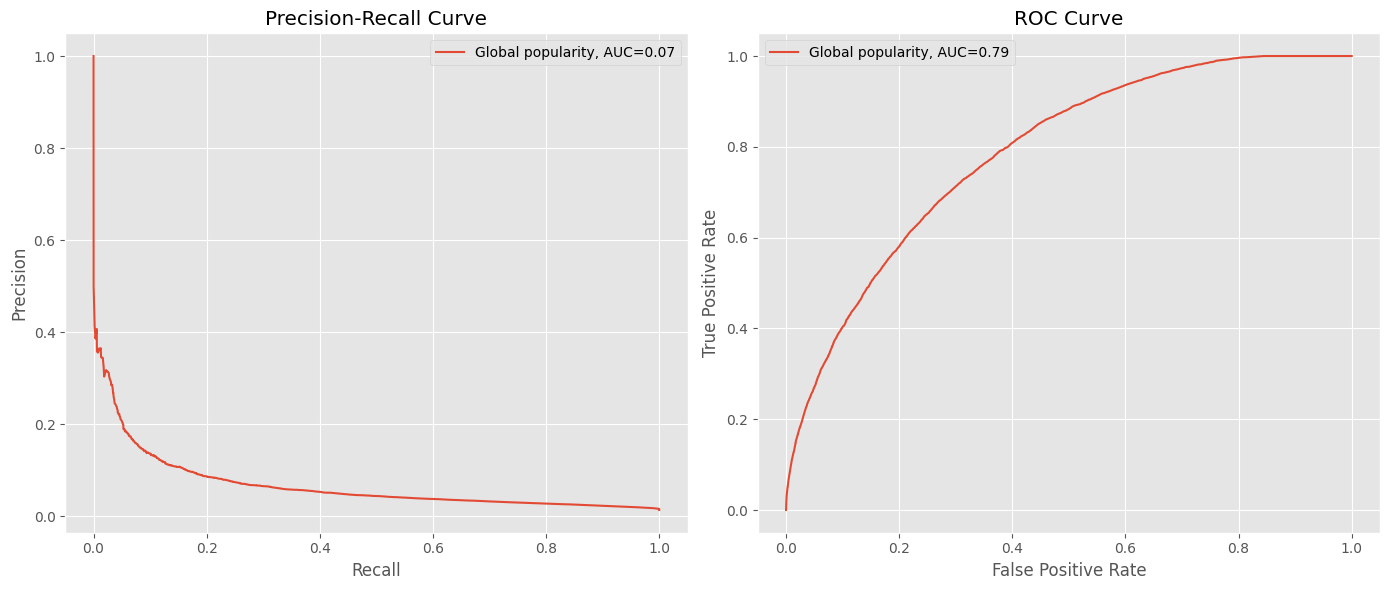

In [10]:
plot_metrics("Global popularity", val_data["global_popularity"], val_data[target_col])

We will use this model that only uses the `global_popularity` feature for\
prediction as our base model.


## Model training


In [11]:
from typing import Tuple


def target_split(df: pd.DataFrame, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    return df.drop(target_col, axis=1), df[target_col]

In [12]:
X_train, y_train = target_split(train_data, target_col)
X_val, y_val = target_split(val_data, target_col)
X_test, y_test = target_split(test_data, target_col)

First, we will train using only numerical and binary features to see how\
models perform so that we avoid the hassle of handling categorical features.


In [13]:
train_cols = numerical_cols + binary_cols

## Ridge Regression

Now, lets try how a linear model such as ridge regression compares to our base\
model, trained using only the numerical and binary features.


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

Try for different values of regularisation, and see which one is best.


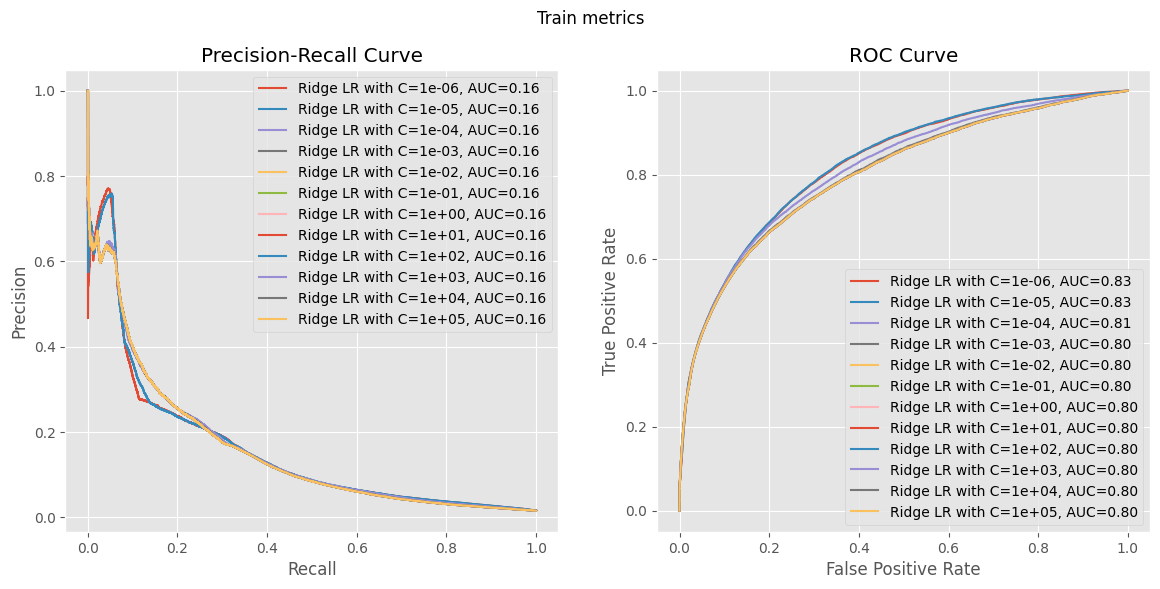

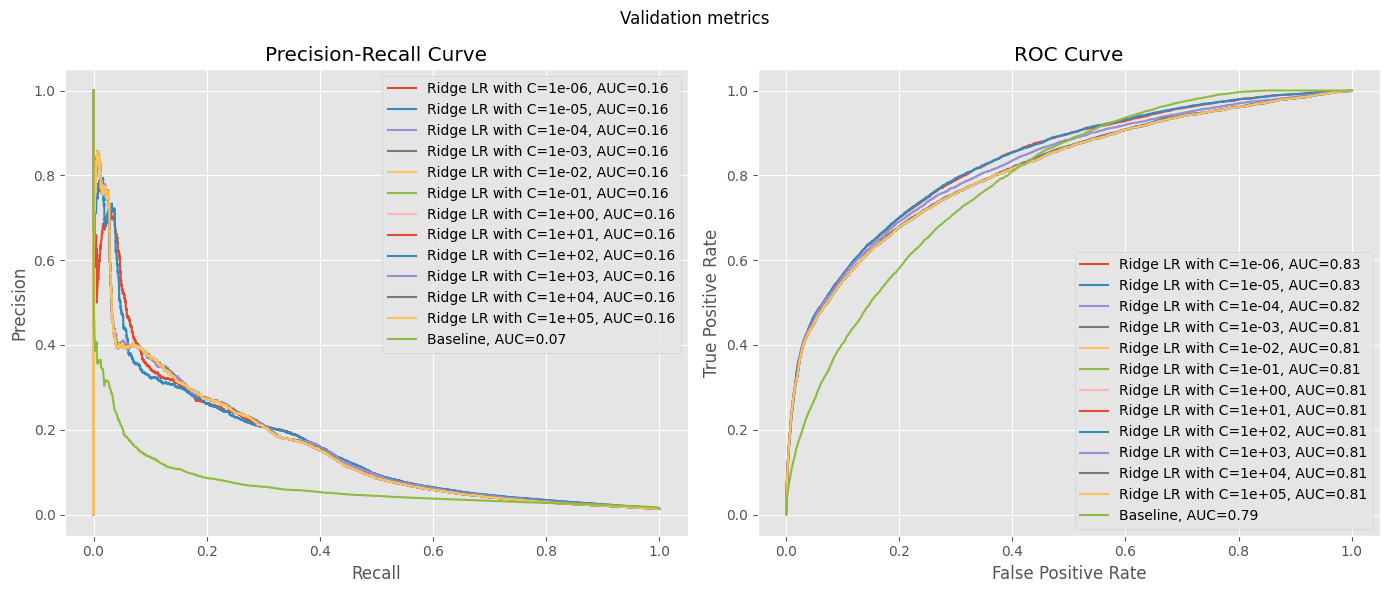

In [15]:
fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
fig2.suptitle("Validation metrics")

C_param = [10**k for k in range(-6, 6)]
for i, c in enumerate(C_param):
    lr = make_pipeline(StandardScaler(), LogisticRegression(penalty="l2", C=c))
    lr.fit(X_train[train_cols], y_train)

    y_train_pred = lr.predict_proba(X_train[train_cols])[:, 1]
    plot_metrics(f"Ridge LR with C={c:.0e}", y_train_pred, y_train, (fig1, ax1))

    y_val_pred = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(f"Ridge LR with C={c:.0e}", y_val_pred, y_val, (fig2, ax2))

plot_metrics(
    "Baseline", val_data["global_popularity"], val_data[target_col], (fig2, ax2)
)

plt.show()

Insights

- Ridge Logistic Regression models are better than the Baseline model.
- Same performance between train and validation, there is no overfitting.
- More regularization improves AUC in ROC Curve.
- Interpretation of ROC Curve. We know that our dataset is extremely unbalanced,\
  with lots of negatives. If we look at the ROC Curve, even a low FPR such as\
  20-30%, is in our problem, very high.


## Lasso Regression


Lets do the same with lasso regression.


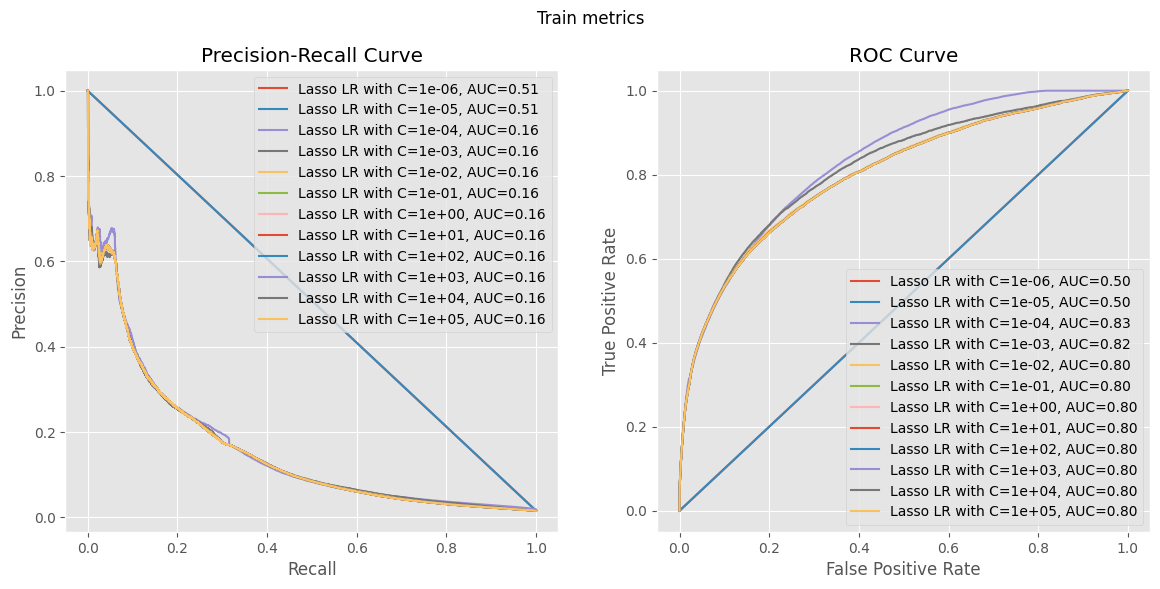

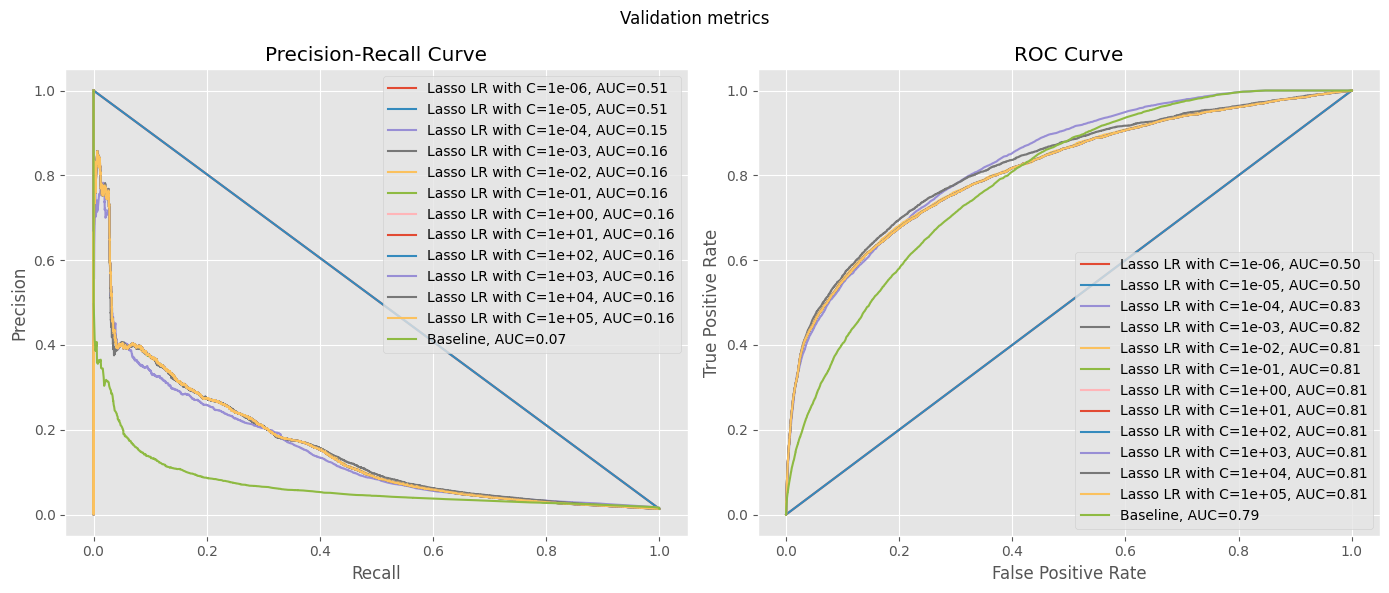

In [16]:
fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
fig2.suptitle("Validation metrics")

C_param = [10**k for k in range(-6, 6)]
for i, c in enumerate(C_param):
    lr = make_pipeline(
        StandardScaler(), LogisticRegression(penalty="l1", C=c, solver="saga")
    )
    lr.fit(X_train[train_cols], y_train)

    y_train_pred = lr.predict_proba(X_train[train_cols])[:, 1]
    plot_metrics(f"Lasso LR with C={c:.0e}", y_train_pred, y_train, (fig1, ax1))

    y_val_pred = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(f"Lasso LR with C={c:.0e}", y_val_pred, y_val, (fig2, ax2))

plot_metrics(
    "Baseline", val_data["global_popularity"], val_data[target_col], (fig2, ax2)
)

plt.show()

Insights

- Ridge and Lasso have similar if not the same performance. So, we will prefer\
  Lasso as it normally uses less features.
- Same insights as Ridge.
- More regularization improves the model, but it also plateaus, in this case\
  when C=1e-3.
- Large regularisation makes it predict randomly. For C=1e-06 and C=1e-05, the\
  PR Curve is wrong, in reality, it only contains two points, either predict all\
  1's or all 0's. Look at ROC Curve for better interpretation.


## Analysis of Coefficient weights

We will use each model's best performing parameters for the analysis.


In [17]:
best_ridge_C = 1e-6
best_lasso_C = 1e-3
lr_ridge = make_pipeline(
    StandardScaler(), LogisticRegression(penalty="l2", C=best_ridge_C)
)
lr_ridge.fit(X_train[train_cols], y_train)

lr_lasso = make_pipeline(
    StandardScaler(), LogisticRegression(penalty="l1", C=best_lasso_C, solver="saga")
)
lr_lasso.fit(X_train[train_cols], y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.001, penalty='l1', solver='saga'))])

<Axes: title={'center': 'Feature coefficients for lasso and ridge models'}, xlabel='features', ylabel='value'>

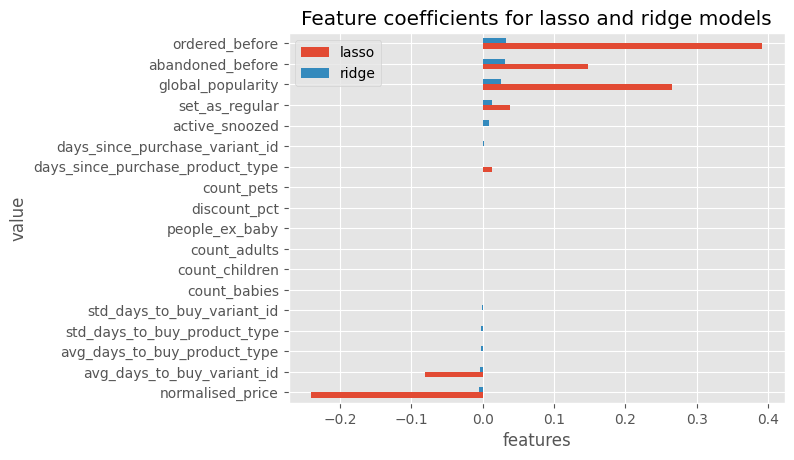

In [18]:
lr_coefficients = pd.DataFrame(
    {
        "columns": X_train[train_cols].columns,
        "lasso": lr_lasso[-1].coef_[0],
        "ridge": lr_ridge[-1].coef_[0],
    }
)
lr_coefficients.sort_values("ridge", ascending=True, inplace=True)
lr_coefficients.plot(
    kind="barh",
    x="columns",
    y=["lasso", "ridge"],
    xlabel="features",
    ylabel="value",
    title="Feature coefficients for lasso and ridge models",
)

Insights:

- There are some features that seem to be the ones that help the most when\
  predicting `outcome`, which are: `ordered_before`, `abandoned_before`, and\
  `global_popularity` and `set_as_regular`  kind of.


## Simplified Lasso and Ridge Regression

Train lasso and ridge regression models that only use the most important features\
seen in the previous section.


In [19]:
train_cols = ["ordered_before", "abandoned_before", "global_popularity"]
lr_lasso_simplified = make_pipeline(
    StandardScaler(), LogisticRegression(penalty="l1", C=best_lasso_C, solver="saga")
)
lr_lasso_simplified.fit(X_train[train_cols], y_train)

lr_ridge_simplified = make_pipeline(
    StandardScaler(), LogisticRegression(penalty="l2", C=best_ridge_C)
)
lr_ridge_simplified.fit(X_train[train_cols], y_train)

train_cols = [
    "ordered_before",
    "abandoned_before",
    "global_popularity",
    "set_as_regular",
]
lr_ridge_mid_simplified = make_pipeline(
    StandardScaler(), LogisticRegression(penalty="l2", C=best_ridge_C)
)
lr_ridge_mid_simplified.fit(X_train[train_cols], y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1e-06))])

In [20]:
from dataclasses import dataclass


@dataclass
class LinearModel:
    model_name: str
    lr: LogisticRegression
    train_cols: list[str]
    C: float

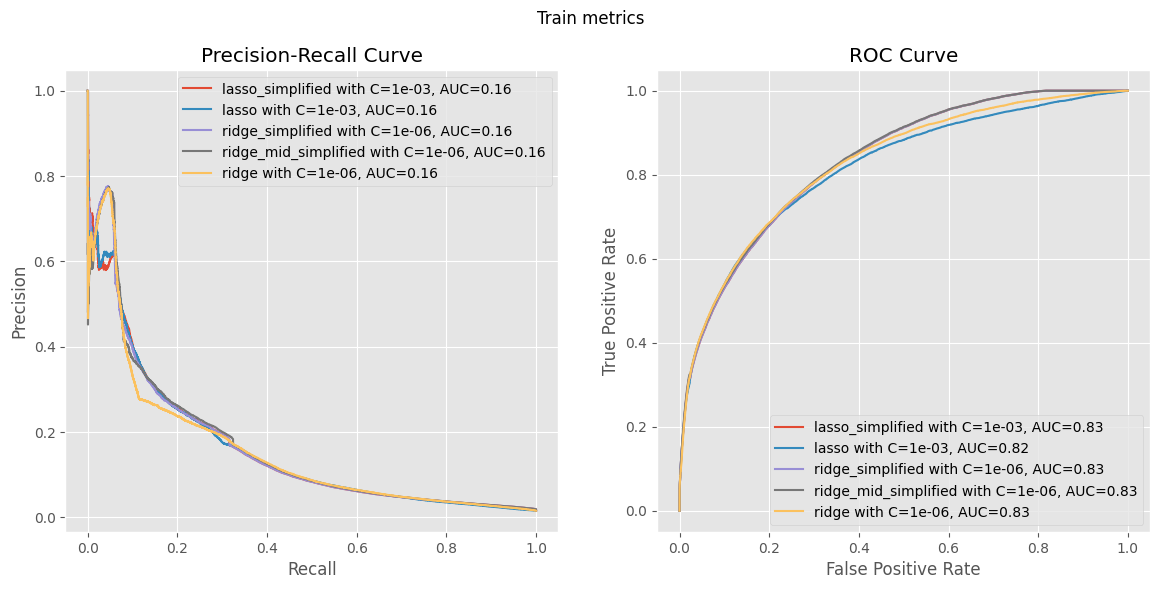

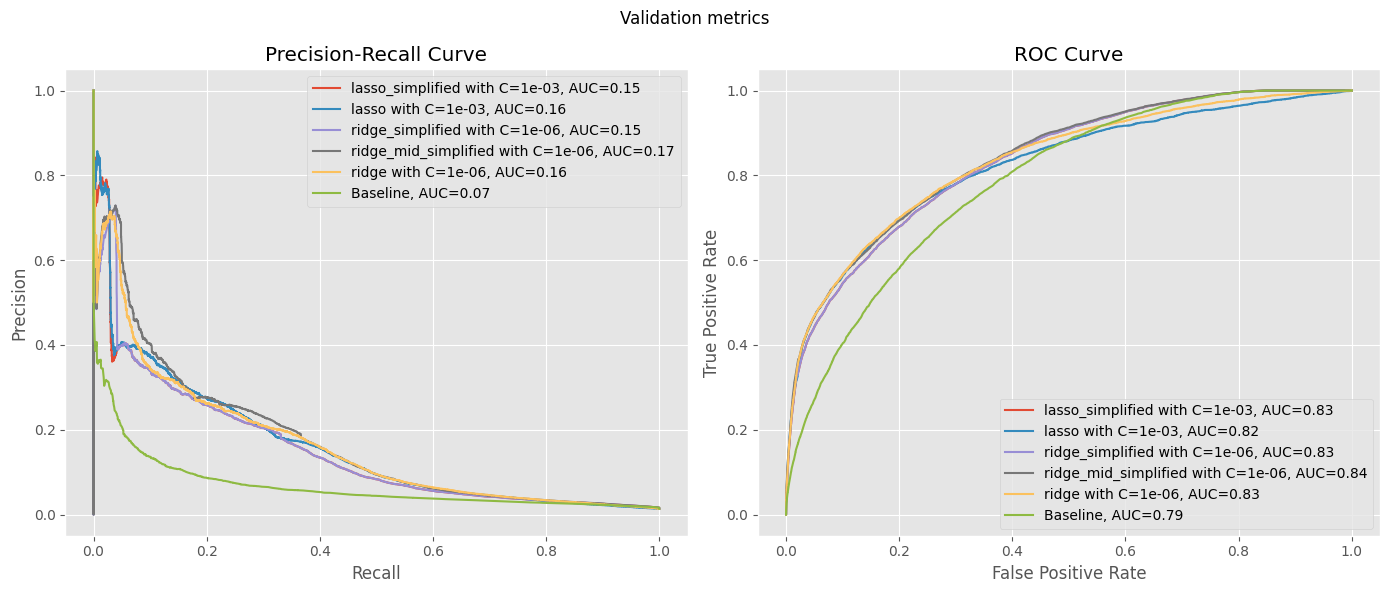

In [21]:
fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
fig2.suptitle("Validation metrics")

models_to_compare = [
    LinearModel(
        model_name="lasso_simplified",
        lr=lr_lasso_simplified,
        train_cols=["ordered_before", "abandoned_before", "global_popularity"],
        C=best_lasso_C,
    ),
    LinearModel(
        model_name="lasso",
        lr=lr_lasso,
        train_cols=numerical_cols + binary_cols,
        C=best_lasso_C,
    ),
    LinearModel(
        model_name="ridge_simplified",
        lr=lr_ridge_simplified,
        train_cols=["ordered_before", "abandoned_before", "global_popularity"],
        C=best_ridge_C,
    ),
    LinearModel(
        model_name="ridge_mid_simplified",
        lr=lr_ridge_mid_simplified,
        train_cols=[
            "ordered_before",
            "abandoned_before",
            "global_popularity",
            "set_as_regular",
        ],
        C=best_ridge_C,
    ),
    LinearModel(
        model_name="ridge",
        lr=lr_ridge,
        train_cols=numerical_cols + binary_cols,
        C=best_ridge_C,
    ),
]

for model in models_to_compare:
    y_train_pred = model.lr.predict_proba(X_train[model.train_cols])[:, 1]
    plot_metrics(
        f"{model.model_name} with C={model.C:.0e}", y_train_pred, y_train, (fig1, ax1)
    )

    y_val_pred = model.lr.predict_proba(X_val[model.train_cols])[:, 1]
    plot_metrics(
        f"{model.model_name} with C={model.C:.0e}", y_val_pred, y_val, (fig2, ax2)
    )

plot_metrics(
    "Baseline", val_data["global_popularity"], val_data[target_col], (fig2, ax2)
)

plt.show()

Insights

- `lasso_simplified` performs the same as the Lasso one trained with all\
  the features. Thus, we will prefer the simplified version, which will be\
  faster at both training and predicting.
- `ridge_mid_simplified` model performs equal or better than the other ridge\
  versions we will use this model.
- We will use the `ridge_mid_simplified` going on because it seems to be the\
  best performing one and kind of simple.


In [22]:
best_model = LinearModel(
    model_name="ridge_mid_simplified",
    lr=lr_ridge_mid_simplified,
    train_cols=[
        "ordered_before",
        "abandoned_before",
        "global_popularity",
        "set_as_regular",
        # "active_snoozed",
    ],
    C=best_ridge_C,
)

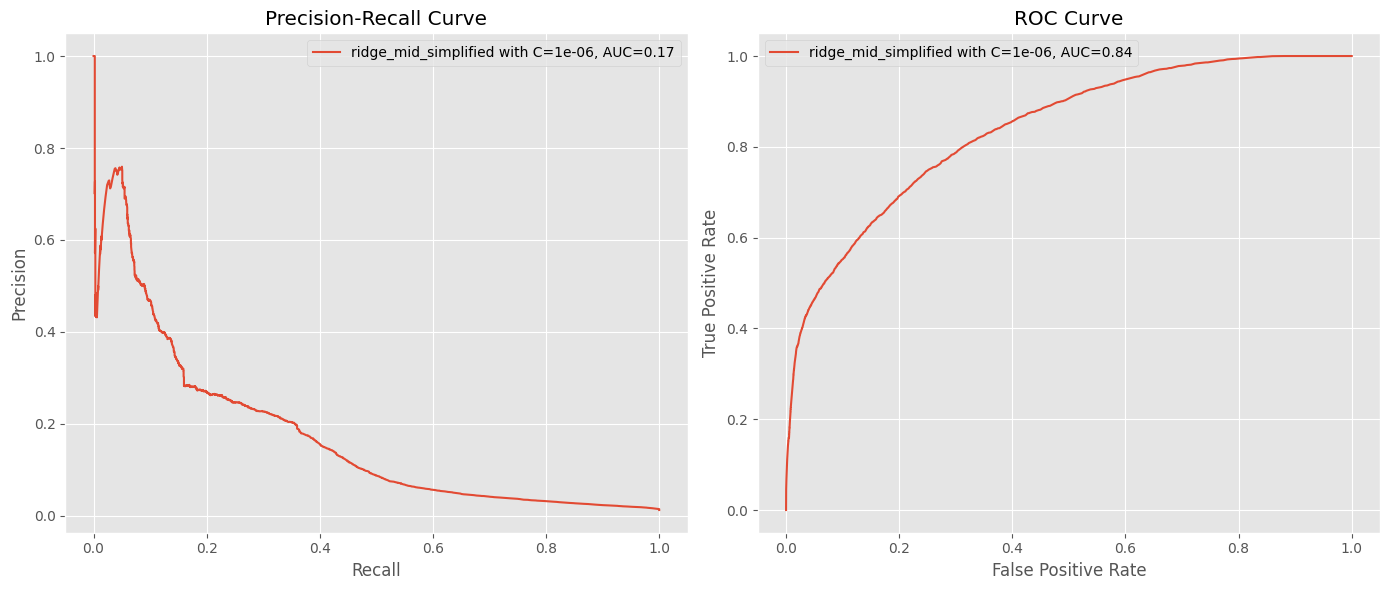

In [23]:
y_test_pred = best_model.lr.predict_proba(X_test[best_model.train_cols])[:, 1]
plot_metrics(f"{best_model.model_name} with C={best_model.C:.0e}", y_test_pred, y_test)

In [24]:

from sklearn.metrics import precision_recall_curve, f1_score

precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred)

# Calculate F1 score for each precision-recall pair at different thresholds
f1_scores = []
for i in range(len(thresholds)):
    f1_scores.append(f1_score(y_test, y_test_pred >= thresholds[i]))

max_f1_index = np.argmax(f1_scores)

optimal_threshold = thresholds[max_f1_index]

print("Optimal threshold:", optimal_threshold)
print("Maximum F1 score:", f1_scores[max_f1_index])


Optimal threshold: 0.01821537339520326
Maximum F1 score: 0.260587942202292


Although the optimal threshold depends on the specific business problem, such\
as the cost of False Positives, etc. because I do not have the information\
regarding these aspects of the business problem, I would have to ask. For now,\
I've decided to use the threshold that has the maximum f1 score which is\
0.01821537339520326.

## Categorical encoding

Analyse if including categorical features improves the model's predictions.\

As seen in the EDA, `product_type` and `vendor` categorical features have high\
cardinality, so encodings that use a lot of columns are not desirable, as they\
increase the dimensionality too much (e.g. one-hot/dummy/binary encoding).\
Also, there is no ordinal relationship between categories, so we discard ordinal\
encoding and label encoding. In this case, I will perform frequency encoding to\
see how it goes, but there are other methods that can work too.

Not enough time to do. To be continued...
